# Music Genre Classification using Traditional Machine Learning

This notebook implements a hierarchical music genre classification system using traditional machine learning approaches. Unlike deep learning methods, it employs classical techniques:

## Key Features:
- Feature extraction from three types of spectrograms (mel, CQT, and chroma)
- Dimensionality reduction using Incremental PCA
- Gradient Boosting Classifiers for multi-level genre prediction
- Memory-efficient batch processing for large-scale data

## Classification Levels:
1. First level: Binary classification (Classic vs Non-classic)
2. Second level: 9 genre categories
3. Third level: 16 detailed sub-genres

## Technical Approach:
- Image preprocessing and flattening for feature extraction
- StandardScaler normalization for feature standardization
- PCA for dimensionality reduction (512 components)
- HistGradientBoostingClassifier with early stopping

## Setup and Imports

In [12]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
from PIL import Image
import io
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report

## Dataset Loading

In [2]:
# Load the dataset
ds = load_dataset("ccmusic-database/music_genre")

# Check the available splits and columns
print(ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['mel', 'cqt', 'chroma', 'fst_level_label', 'sec_level_label', 'thr_level_label'],
        num_rows: 29100
    })
    validation: Dataset({
        features: ['mel', 'cqt', 'chroma', 'fst_level_label', 'sec_level_label', 'thr_level_label'],
        num_rows: 3637
    })
    test: Dataset({
        features: ['mel', 'cqt', 'chroma', 'fst_level_label', 'sec_level_label', 'thr_level_label'],
        num_rows: 3638
    })
})


## Data Frame Creation

In [3]:
# Convert each split to pandas (images will remain as PIL.Image objects)

df_train = ds["train"].to_pandas()
df_val = ds["validation"].to_pandas()
df_test = ds["test"].to_pandas()

print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)

df_train.head()

Train shape: (29100, 6)
Validation shape: (3637, 6)
Test shape: (3638, 6)


,mel,cqt,chroma,fst_level_label,sec_level_label,thr_level_label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,4,6
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,4,6
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,8,12
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,8,14
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,4,6


## Data structure analysis

In [4]:
print(df_train.dtypes)

mel                object
cqt                object
chroma             object
fst_level_label     int64
sec_level_label     int64
thr_level_label     int64
dtype: object


## Spectrogram Visualisation

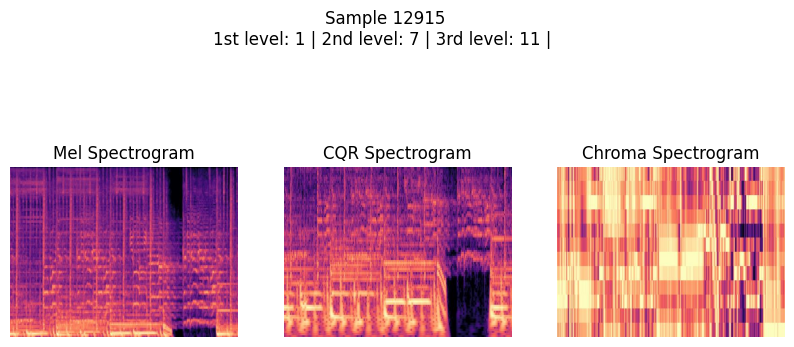

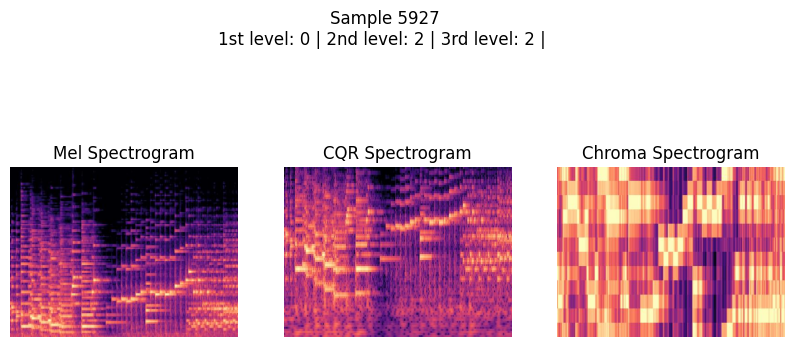

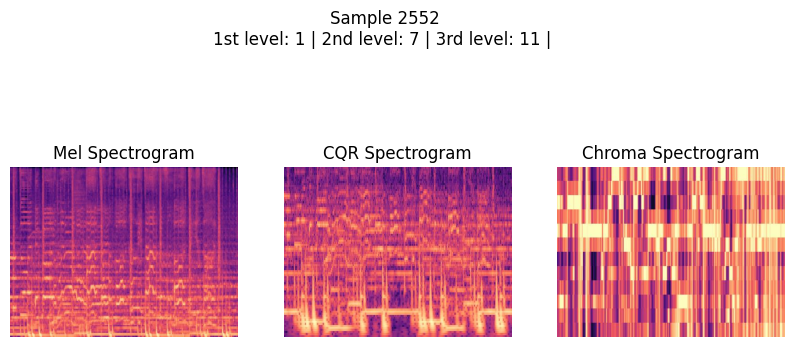

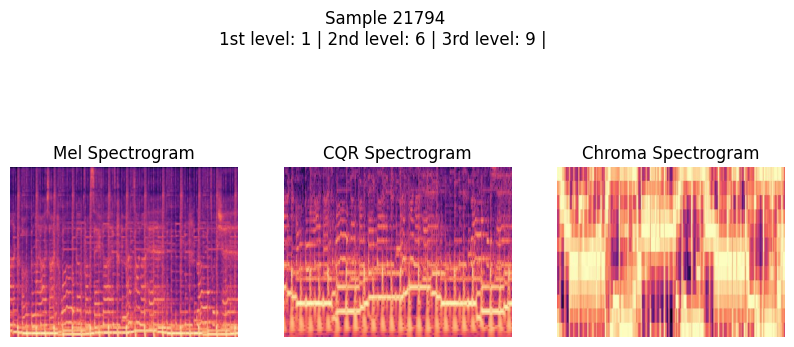

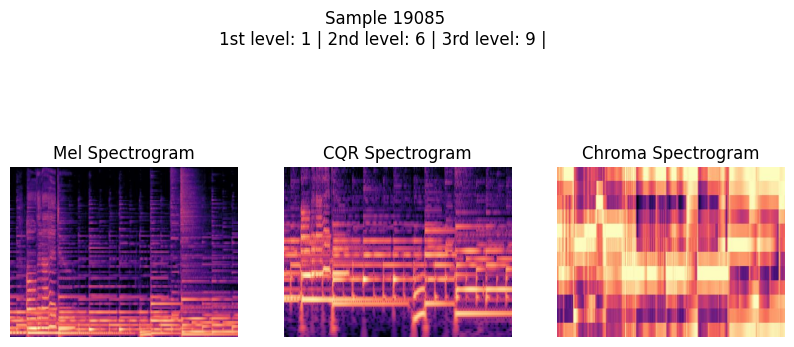

In [5]:
# Pick a few random indices
indices = random.sample(range(len(df_train)), 5)

for i in indices:
  row = df_train.iloc[i]

  # decode from bytes to PIL image
  mel_img = Image.open(io.BytesIO(row["mel"]["bytes"]))
  cqt_img = Image.open(io.BytesIO(row["cqt"]["bytes"]))
  chroma_img = Image.open(io.BytesIO(row["chroma"]["bytes"]))

  # create figure and axes
  fig, axes = plt.subplots(1, 3, figsize=(10, 5))

  # plot mel spectrogram
  axes[0].imshow(mel_img)
  axes[0].set_title("Mel Spectrogram")
  axes[0].axis("off")

  # plot cqt spectrogram
  axes[1].imshow(cqt_img)
  axes[1].set_title("CQR Spectrogram")
  axes[1].axis("off")

  # plot chroma spectrogram
  axes[2].imshow(chroma_img)
  axes[2].set_title("Chroma Spectrogram")
  axes[2].axis("off")

  plt.suptitle(
      f"Sample {i}\n"
      f"1st level: {row['fst_level_label']} | "
      f"2nd level: {row['sec_level_label']} | "
      f"3rd level: {row['thr_level_label']} | "
  )
  plt.show()


## Label Distribution Analysis

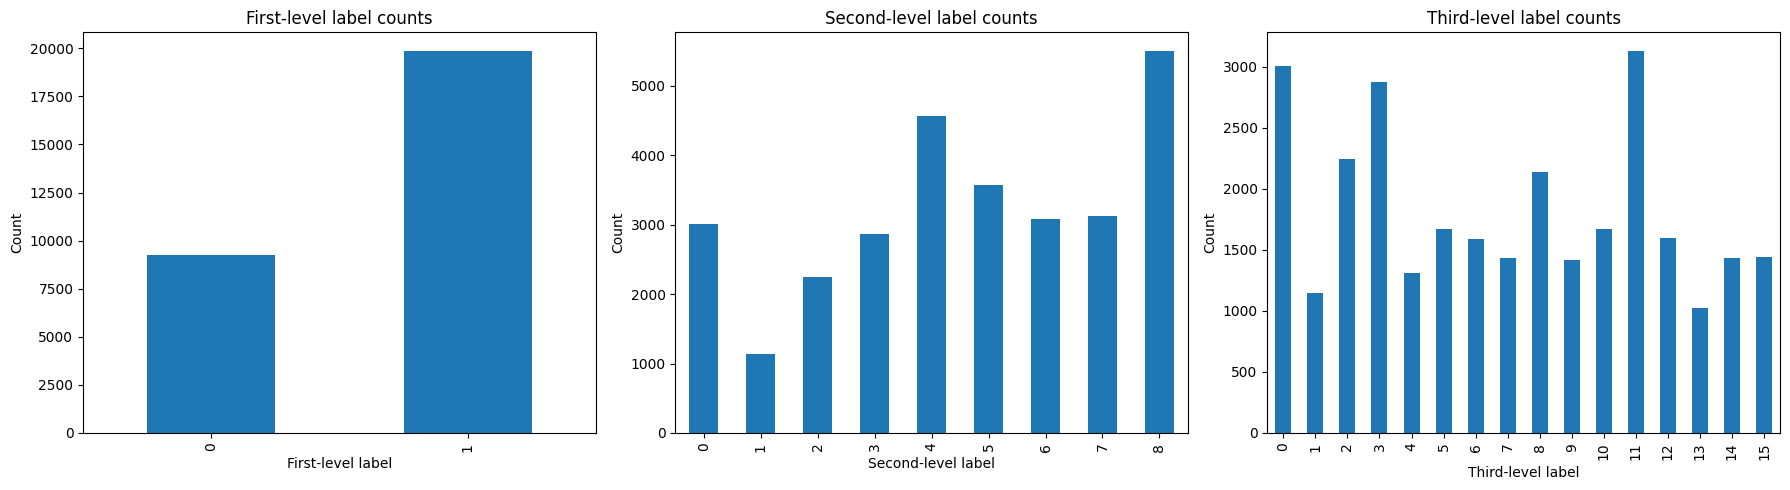

In [6]:
# get label columns from df_train
fst_labels = df_train["fst_level_label"]
sec_labels = df_train["sec_level_label"]
thr_labels = df_train["thr_level_label"]

# plot histograms side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

fst_labels.value_counts().sort_index().plot(
    kind="bar", ax=axes[0], title="First-level label counts"
)
sec_labels.value_counts().sort_index().plot(
    kind="bar", ax=axes[1], title="Second-level label counts"
)
thr_labels.value_counts().sort_index().plot(
    kind="bar", ax=axes[2], title="Third-level label counts"
)

axes[0].set_xlabel("First-level label")
axes[0].set_ylabel("Count")
axes[1].set_xlabel("Second-level label")
axes[1].set_ylabel("Count")
axes[2].set_xlabel("Third-level label")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

## Feature Extraction

In [7]:
# Preprocess images into feature vectors

# function to decode and flatten all 3 spectrograms into one vector
def row_to_features(row, size=(128,128)):
  mel = Image.open(io.BytesIO(row["mel"]["bytes"])).convert("L").resize(size)
  cqt = Image.open(io.BytesIO(row["cqt"]["bytes"])).convert("L").resize(size)
  chroma = Image.open(io.BytesIO(row["chroma"]["bytes"])).convert("L").resize(size)

  mel_arr = np.asarray(mel, dtype=np.float32).flatten() / 255.0
  cqt_arr = np.asarray(cqt, dtype=np.float32).flatten() / 255.0
  chroma_arr = np.asarray(chroma, dtype=np.float32).flatten() / 255.0

  return np.concatenate((mel_arr, cqt_arr, chroma_arr))

# build feature matrices for each split
X_train = np.stack(df_train.apply(row_to_features, axis=1).values)
X_val = np.stack(df_val.apply(row_to_features, axis=1).values)
X_test = np.stack(df_test.apply(row_to_features, axis=1).values)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (29100, 49152)
Validation shape: (3637, 49152)
Test shape: (3638, 49152)


## Dimensionality Reduction

In [8]:
# Scale + PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# pick number of PCA components
N_COMPONENTS = 512
BATCH_SIZE = 512



# set up Incremental PCA
ipca = IncrementalPCA(n_components=N_COMPONENTS, batch_size=BATCH_SIZE)
for i in tqdm(range(0, X_train_scaled.shape[0], BATCH_SIZE)):
    batch = X_train_scaled[i:i+BATCH_SIZE]
    ipca.partial_fit(batch)

print("Transforming train set...")
X_train_pca = np.vstack([
    ipca.transform(X_train_scaled[i:i+BATCH_SIZE])
    for i in tqdm(range(0, X_train_scaled.shape[0], BATCH_SIZE))
])


print("Transforming validation set...")
X_val_pca = np.vstack([
    ipca.transform(X_val_scaled[i:i+BATCH_SIZE])
    for i in tqdm(range(0, X_val_scaled.shape[0], BATCH_SIZE))
])

print("Transforming test set...")
X_test_pca = np.vstack([
    ipca.transform(X_test_scaled[i:i+BATCH_SIZE])
    for i in tqdm(range(0, X_test_scaled.shape[0], BATCH_SIZE))
])

print("Shapes:")
print("Train:", X_train_pca.shape)
print("Validation:", X_val_pca.shape)
print("Test:", X_test_pca.shape)

100%|██████████| 57/57 [07:49<00:00,  8.24s/it]


Transforming train set...


100%|██████████| 57/57 [00:12<00:00,  4.41it/s]


Transforming validation set...


100%|██████████| 8/8 [00:01<00:00,  5.70it/s]


Transforming test set...


100%|██████████| 8/8 [00:01<00:00,  5.78it/s]

Shapes:
Train: (29100, 512)
Validation: (3637, 512)
Test: (3638, 512)


## Model Configuration + Training and Validation

In [9]:
# Train + evaluate a model per level

# helper to train and evaluate one target
def train_and_evaluate(target, X_train_p, y_train, X_val_p, y_val, X_test_p, y_test):
  print(f"\n===== Training for {target} =====")

  clf = HistGradientBoostingClassifier(
      learning_rate=0.05,
      max_leaf_nodes=63,
      random_state=42,
      early_stopping=True,
  )
  clf.fit(X_train_p, y_train)

  # validation
  val_preds = clf.predict(X_val_p)
  print("\nValidation report:")
  print(classification_report(y_val, val_preds))

  # test
  test_preds = clf.predict(X_test_p)
  print("\nTest report:")
  print(classification_report(y_test, test_preds))

  return clf

# train models for each level
clf_fst = train_and_evaluate("First-level", X_train_pca, df_train["fst_level_label"], X_val_pca, df_val["fst_level_label"], X_test_pca, df_test["fst_level_label"])
clf_sec = train_and_evaluate("Second-level", X_train_pca, df_train["sec_level_label"], X_val_pca, df_val["sec_level_label"], X_test_pca, df_test["sec_level_label"])
clf_thr = train_and_evaluate("Third-level", X_train_pca, df_train["thr_level_label"], X_val_pca, df_val["thr_level_label"], X_test_pca, df_test["thr_level_label"])



===== Training for First-level =====

Validation report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1176
           1       0.98      0.96      0.97      2461

    accuracy                           0.96      3637
   macro avg       0.95      0.96      0.96      3637
weighted avg       0.96      0.96      0.96      3637


Test report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1165
           1       0.98      0.96      0.97      2473

    accuracy                           0.96      3638
   macro avg       0.95      0.96      0.95      3638
weighted avg       0.96      0.96      0.96      3638


===== Training for Second-level =====

Validation report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       389
           1       0.91      0.51      0.66       150
           2       0.81      0.93      0.86       26

## Results Analysis, Performance Visualization

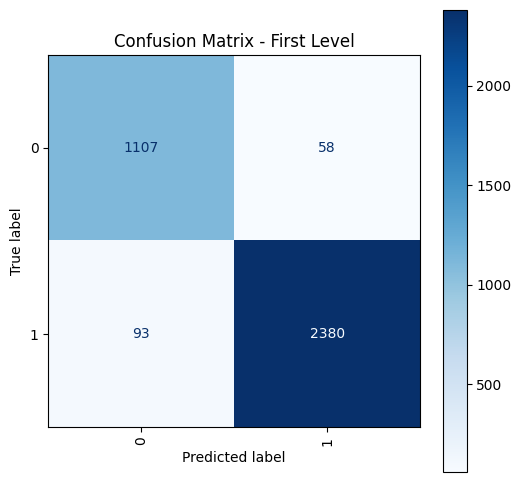

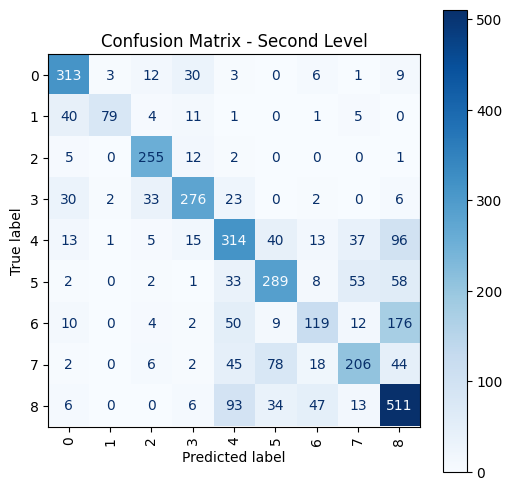

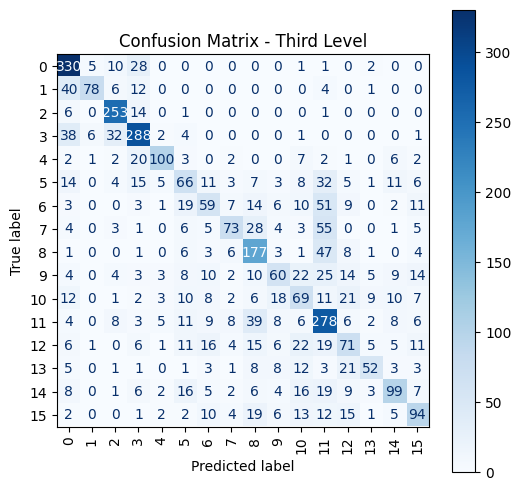

In [13]:

# helper function to plot confusion matrix
def plot_conf_matrix(clf, X, y, title):
    preds = clf.predict(X)
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay.from_predictions(
        y, preds, cmap="Blues", xticks_rotation=90, ax=ax
    )
    ax.set_title(title)
    plt.show()

# First-level
plot_conf_matrix(clf_fst, X_test_pca, df_test["fst_level_label"], "Confusion Matrix - First Level")

# Second-level
plot_conf_matrix(clf_sec, X_test_pca, df_test["sec_level_label"], "Confusion Matrix - Second Level")

# Third-level
plot_conf_matrix(clf_thr, X_test_pca, df_test["thr_level_label"], "Confusion Matrix - Third Level")
